## Analyze training separately for FO Calendar Quarters

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')
from src.lifetime_dev.VPLifetimesData import VPLifetimesData
from src.lifetime_dev.VPLifetimesHoldoutPlots import VPLifetimesHoldoutPlots
from src.lifetime_dev.VPLifetimesAnalysis import VPLifetimesAnalysis
from src.lifetime_dev.VPLifetimesOrderPredictAnalyze import VPLifetimesOrderPredictAnalyze
from src.lifetime_dev.VPLifetimesHoldoutMetrics import VPLifetimesHoldoutMetrics
from pathlib import Path
from kedro.framework.context import load_context
pd.options.display.max_columns = None

start_date = '2010-07-01'
end_date = '2020-08-01'
project_path = Path(os.getcwd()).parents[0].resolve()  
context = load_context(project_path)
orders_df = context.catalog.load("ie_es_2010_2020")
orders_df.AGP_BUDGET_USD = orders_df.AGP_BUDGET_USD.astype('float64')
orders_df['ORDER_DATE_DT'] = pd.to_datetime(orders_df.ORDER_DATE, format='%Y-%m-%d')

country_field = 'ACCOUNT_CREATION_COUNTRY'
order_date_field = 'ORDER_DATE'
param_fields = ['b-r', 'b-alpha', 'b-a', 'b-b', 'g-p', 'g-q', 'g-v']
fit_results = {}
rows = []
calibration_period_end = '2019-09-30'

lifetimes version: 0.11.3
2020-08-08 20:51:49,550 - kedro.io.data_catalog - INFO - Loading data from `ie_es_2010_2020` (PickleDataSet)...


c:\users\mandersen\anaconda3\envs\py37\lib\site-packages\kedro\framework\context\context.py:538: UserWarning: Credentials not found in your Kedro project config.
No files found in ['C:\\repo\\lifetime-dev\\conf\\base', 'C:\\repo\\lifetime-dev\\conf\\local'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  str(exc)


In [2]:
def segment_first_order_quarter(order_df):
    """
    Mark's customers based on first order.
    Uses first AGP>0 order rather than shopper first_order_date, as AGP>0 more reliable
    and consistent withthe data.
    
    This will adjust the DataFrame passed in by adding new columns
     - ORDER_RANK (only reliable for first order)
     - FO_QUARTER: 1, 2, 3, or 4.  Calendar quarter
     - FO_YEAR: first order year
     
    Returns dataframe with these new columns added
    """
    #
    original_order_len = len(order_df)
    #
    # method=min needed to allow ties to come out as 1.0.  Cannot rely on any other rank value
    # N.B. since we do not need the product fields this could have been de-duplicated first
    # to avoid ties.  Would avoid the drop_duplicates() before merge below.
    order_df['ORDER_RANK'] = order_df.groupby(['SHOPPER_ID']).ORDER_DATE_DT.rank(method='min')
    agp_first = order_df[order_df.ORDER_RANK==1.0]

    agp_first['FO_QUARTER'] = agp_first.ORDER_DATE_DT.dt.month.div(4).round(0) + 1
    agp_first['FO_YEAR'] = agp_first.ORDER_DATE_DT.dt.year
        
    # get unique values per shopper
    agp_first = agp_first[['SHOPPER_ID', 'FO_QUARTER', 'FO_YEAR']].drop_duplicates()
    
    order_df = order_df.merge(agp_first, how='inner', on='SHOPPER_ID')
    final_order_len = len(order_df)

    assert final_order_len == original_order_len, \
        f'Data merge issue length should be {original_order_len} but is now {final_order_len}'
    return order_df


In [3]:
aug_df = segment_first_order_quarter(orders_df)

### Suspicious data 
* Appears to be upstream at various dim tables so we understand this analysis is limited by this

In [4]:
for country in ['ES']:  #  ['IE', 'ES']:  # showing only ES for brevity
    df = aug_df[aug_df.ACCOUNT_CREATION_COUNTRY == country]
    print(country)
    print(df.FO_QUARTER.value_counts())
    print(df.FO_YEAR.value_counts())
    

ES
3.0    838499
4.0    756290
2.0    527394
1.0    428933
Name: FO_QUARTER, dtype: int64
2012    437111
2011    405535
2013    380792
2014    302215
2010    254775
2015    230491
2016    183967
2017    160149
2018    109347
2019     66263
2020     20471
Name: FO_YEAR, dtype: int64


## Analyze data separately for FO calendar quarters

In [5]:
def score_dataframe(df, cohort_name, descriptor, file_base_name, model_type, calibration_period_end, obs_date):
    """
    scores dataframe: returns df with the scores and a results dictionary
    
    df: dataset to score
    cohort_name: how to name cohort
    descriptor: title for describing
    file_base_name: filename for naming
    model_type: type of predictor
    calibration_period_end: string for date
    obs_date: string for date
    """
    print(f'Scores for {descriptor}')
    life_data = VPLifetimesData(df)

    vp_lifetime_analysis = VPLifetimesAnalysis(life_data)
    vplop = VPLifetimesOrderPredictAnalyze(life_data,
                                           calibration_period_end=calibration_period_end,
                                           observation_period_end=obs_date)
    fit_params, _, _ = vplop.calibration(vp_lifetime_analysis, model_type, 0.0)
    _ = vplop.calc_order_predictions(vp_lifetime_analysis)

    if False:
        # extra processing time to make graphs
        #
        plots = VPLifetimesHoldoutPlots(vplop.calholddata)
        plots.plot_holdout_frequency_charts(suptitle=f'Frequency holdouts: {descriptor}')
        plt.show()
        plots.plot_model_rank_vs_holdout(suptitle=f'Rank v. holdout: {descriptor}')
        plt.show()

    temp = vplop.calholddata.copy()
    temp = temp.reset_index()
    temp.rename(columns={'model_prediction_bookings': 'predict_total_spend',
                         'model_predictions': 'predict_order_count',
                         'SHOPPER_ID': 'id'}, inplace=True)

    # pare down the columns to avoid conflict based renames on merge
    comparison = VPLifetimesHoldoutMetrics(temp[['id', 'frequency_holdout', 'monetary_value_holdout']],
                                         temp[['id', 'predict_order_count', 'predict_total_spend']])
    results = {
        'country': country,
        'cohort': cohort_name,
        'start_date': start_date,
        'obs_date': obs_date,
        'calibration_period_end': calibration_period_end,
        'num_shoppers': len(temp)
    }
    for key in fit_params:
        results[key] = fit_params[key]
    for key in comparison.base_metrics:
        results[key] = comparison.base_metrics[key]
    return temp, results


In [6]:
import numpy as np
pd.options.display.max_columns = None
countries = ['IE', 'ES']
obs_date = end_date
model_type = 'ModifiedBetaGeo'
model_results = []
country_combined = {}
combo_comparisons = {}
combo_results = []
base_dfs = {}
for country in countries:
    country_df = aug_df[aug_df[country_field] == country].copy()
    
    # Baseline Metric - Whole Data Set
    descriptor = f'{country}-cal:{calibration_period_end}-obs thru:{obs_date} ModelType:{model_type} base'
    file_base_name = f'{country}-calend-{calibration_period_end}-obs-{obs_date}-model-{model_type}-base'
    base_dfs[country], results = score_dataframe(country_df, 'base', descriptor, file_base_name, model_type, calibration_period_end, obs_date)
    model_results.append(results)
    
    dfs = []
    for fo_quarter in np.arange(1, 5):
        df = country_df[country_df.FO_QUARTER == fo_quarter]
    
        #descriptor = f'{country}-cal:{calibration_period_end}-obs thru:{obs_date} ModelType:{model_type} freq:{freq}'
        descriptor = f'{country} - FO quarter {fo_quarter}'
        df_result, results = score_dataframe(df, str(fo_quarter), 
                                     descriptor, file_base_name, model_type, calibration_period_end, obs_date)
        dfs.append(df_result)
        model_results.append(results)
    country_combined[country] = pd.concat(dfs)

    # combined analysis
    if True:
        combo = country_combined[country]
        gt = combo[['id', 'frequency_holdout', 'monetary_value_holdout']]
        predictions = combo[['id', 'predict_order_count', 'predict_total_spend']]
        combo_comparison = VPLifetimesHoldoutMetrics(gt, predictions)
        results = {
            'country': country,
            'cohort': f'fo_quarters: combined',
            'start_date': start_date,
            'obs_date': obs_date,
            'calibration_period_end': calibration_period_end,
            'num_shoppers': len(combo)
        }
        # fit_params make no sense for combined model so skipped
        for key in combo_comparison.base_metrics:
            results[key] = combo_comparison.base_metrics[key]
        combo_results.append(results)

results_df = pd.DataFrame.from_dict(model_results)
combo_results_df = pd.DataFrame.from_dict(combo_results)
combo_results_df


Scores for IE-cal:2019-09-30-obs thru:2020-08-01 ModelType:ModifiedBetaGeo base
2020-08-08 20:52:15,762 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 348174
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-08 20:52:22,646 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 126075 subjects, p: 1.85, q: 4.10, v: 50.29>
Scores for IE - FO quarter 1
2020-08-08 20:52:25,068 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 50679
Model type set to ModifiedBetaGeo.  Fit results cleared.
2020-08-08 20:52:26,032 - src.lifetime_dev.VPLifetimesAnalysis - INFO - <lifetimes.GammaGammaFitter: fitted with 18358 subjects, p: 1.87, q: 4.25, v: 54.57>
Scores for IE - FO quarter 2
2020-08-08 20:52:28,096 - src.lifetime_dev.VPLifetimesOrderPredictAnalyze - INFO - Trying to fit order model with length 72881
Model type set to ModifiedBetaGeo.  Fit results cle

country                 cohort  start_date    obs_date  \
0      IE  fo_quarters: combined  2010-07-01  2020-08-01   
1      ES  fo_quarters: combined  2010-07-01  2020-08-01   

  calibration_period_end  num_shoppers  numorder_mae  numorder_rmse  \
0             2019-09-30        348174      0.117682       0.324453   
1             2019-09-30        896267      0.099968       0.297726   

   numorder_predicted_orders  numorder_actual_orders  ...  \
0               32260.089986                 21480.0  ...   
1               68875.364349                 60369.0  ...   

   mval_predicted_per_customer  mval_actual_per_customer  mval_rspearman  \
0                     3.037333                  1.292701        0.239064   
1                     2.098934                  1.221754        0.301860   

   cond_mon_mae  cond_mon_rmse  cond_mon_predicted_mean  cond_mon_actual_mean  \
0     18.605218      46.917804                17.214085             28.788852   
1     14.557023      28.328443                13.594220             23.606647   

   cond_mon_predicted_per_customer  cond_mon_actual_per_customer  \
0                        32.052201                     24.543287   
1                        26.310591                     20.669664   

   cond_mon_rspearman  
0            0.268371  
1            0.371190  

[2 rows x 27 columns]

In [7]:
results_df

country cohort  start_date    obs_date calibration_period_end  num_shoppers  \
0      IE   base  2010-07-01  2020-08-01             2019-09-30        348174   
1      IE      1  2010-07-01  2020-08-01             2019-09-30         50679   
2      IE      2  2010-07-01  2020-08-01             2019-09-30         72881   
3      IE      3  2010-07-01  2020-08-01             2019-09-30        123532   
4      IE      4  2010-07-01  2020-08-01             2019-09-30        101082   
5      ES   base  2010-07-01  2020-08-01             2019-09-30        896267   
6      ES      1  2010-07-01  2020-08-01             2019-09-30        157214   
7      ES      2  2010-07-01  2020-08-01             2019-09-30        193447   
8      ES      3  2010-07-01  2020-08-01             2019-09-30        291580   
9      ES      4  2010-07-01  2020-08-01             2019-09-30        254026   

        b-r     b-alpha       b-a       b-b  ...  mval_predicted_per_customer  \
0  0.633934  196.690421  1.391678  1.402330  ...                     3.023208   
1  0.605868  183.790269  1.483806  1.495033  ...                     3.076218   
2  0.570329  168.500281  1.447662  1.475909  ...                     3.225103   
3  0.559191  157.112965  1.481732  1.593489  ...                     3.321691   
4  1.092183  393.962002  1.177398  0.986369  ...                     2.534941   
5  0.949944  258.613020  1.302610  0.987813  ...                     2.097494   
6  0.882448  244.772188  1.343928  0.962614  ...                     1.903398   
7  0.753055  199.035755  1.387495  1.037867  ...                     2.147579   
8  0.766883  194.226953  1.388338  1.103451  ...                     2.188414   
9  1.683137  505.543279  1.177990  0.899647  ...                     2.080197   

   mval_actual_per_customer  mval_rspearman  cond_mon_mae  cond_mon_rmse  \
0                  1.292701        0.239324     18.593854      46.923347   
1                  1.243676        0.233250     19.160397      28.513022   
2                  1.333954        0.226072     20.828461      83.037693   
3                  1.301664        0.231908     19.654090      37.991270   
4                  1.276583        0.260693     15.739053      25.443434   
5                  1.221754        0.301711     14.604681      28.318625   
6                  1.080068        0.281859     14.782349      34.520786   
7                  1.019294        0.254785     15.725213      23.106649   
8                  1.019686        0.260749     15.894662      30.381187   
9                  1.695562        0.381335     13.118641      26.273381   

   cond_mon_predicted_mean  cond_mon_actual_mean  \
0                17.174225             28.788852   
1                18.307759             28.675280   
2                18.230053             31.001253   
3                19.568799             29.514899   
4                13.418032             26.595125   
5                13.577153             23.606647   
6                13.809095             23.570500   
7                15.942298             24.675172   
8                15.576600             24.342555   
9                11.247998             22.696779   

   cond_mon_predicted_per_customer  cond_mon_actual_per_customer  \
0                        32.055766                     24.543287   
1                        33.315448                     23.889002   
2                        34.074682                     26.580085   
3                        33.802777                     24.700052   
4                        28.207135                     23.347217   
5                        26.461399                     20.669664   
6                        26.530885                     20.610062   
7                        28.824041                     20.938839   
8                        28.381586                     20.735825   
9                        23.835641                     20.536360   

   cond_mon_rspearman  
0            0.264129  
1          

In [8]:
pd.options.display.max_columns = None
compare_df = pd.concat([combo_results_df, results_df[combo_results_df.columns]])
compare_df

country                 cohort  start_date    obs_date  \
0      IE  fo_quarters: combined  2010-07-01  2020-08-01   
1      ES  fo_quarters: combined  2010-07-01  2020-08-01   
0      IE                   base  2010-07-01  2020-08-01   
1      IE                      1  2010-07-01  2020-08-01   
2      IE                      2  2010-07-01  2020-08-01   
3      IE                      3  2010-07-01  2020-08-01   
4      IE                      4  2010-07-01  2020-08-01   
5      ES                   base  2010-07-01  2020-08-01   
6      ES                      1  2010-07-01  2020-08-01   
7      ES                      2  2010-07-01  2020-08-01   
8      ES                      3  2010-07-01  2020-08-01   
9      ES                      4  2010-07-01  2020-08-01   

  calibration_period_end  num_shoppers  numorder_mae  numorder_rmse  \
0             2019-09-30        348174      0.117682       0.324453   
1             2019-09-30        896267      0.099968       0.297726   
0             2019-09-30        348174      0.117511       0.324480   
1             2019-09-30         50679      0.115573       0.340329   
2             2019-09-30         72881      0.118085       0.321092   
3             2019-09-30        123532      0.122156       0.341019   
4             2019-09-30        101082      0.112980       0.296765   
5             2019-09-30        896267      0.100308       0.298353   
6             2019-09-30        157214      0.091072       0.280780   
7             2019-09-30        193447      0.094999       0.301905   
8             2019-09-30        291580      0.097097       0.299823   
9             2019-09-30        254026      0.112554       0.302261   

   numorder_predicted_orders  numorder_actual_orders  \
0               32260.089986                 21480.0   
1               68875.364349                 60369.0   
0               32134.972801                 21480.0   
1                4501.888500                  3149.0   
2                6804.936546                  4331.0   
3               12028.344814                  7780.0   
4                8924.920125                  6220.0   
5               68791.108711                 60369.0   
6               10842.780999                  9382.0   
7               14244.710256                 11159.0   
8               22256.451190                 16776.0   
9               21531.421903                 23052.0   

   numorder_predicted_per_customer  numorder_actual_per_customer  \
0                         0.092655                      0.061693   
1                         0.076847                      0.067356   
0                         0.092296                      0.061693   
1                         0.088831                      0.062136   
2                         0.093371                      0.059426   
3                         0.097370                      0.062980   
4                         0.088294                      0.061534   
5                         0.076753                      0.067356   
6                         0.068968                      0.059677   
7                         0.073636                      0.057685   
8                         0.076331                      0.057535   
9                         0.084761                      0.090747   

   numorder_rspearman  mval_mae  mval_rmse  mval_predicted   mval_actual  \
0            0.241342  3.340347  14.656789    1.057520e+06  4.500849e+05   
1            0.304077  2.350251  10.300250    1.881205e+06  1.095018e+06   
0            0.241329  3.329733  14.633507    1.052603e+06  4.500849e+05   
1            0.235047  3.322887  12.061816    1.558997e+05  6.302826e+04   
2            0.227690  3.580938  20.553216    2.350487e+05  9.721993e+04   
3            0.233750  3.599260  14.436977    4.103351e+05  1.607972e+05   
4            0.262506  2.859217  10.378235    2.562369e+05  1.290395e+05   
5            0.303395  2.352187  10.291491    1.879914e+06  1.095018e+06   

In [9]:
compare_rows = compare_df[compare_df.cohort.isin(['1', '2', '3', '4']) == False]
compare_rows = compare_rows.sort_values(['country', 'cohort'])
compare_rows

country                 cohort  start_date    obs_date  \
5      ES                   base  2010-07-01  2020-08-01   
1      ES  fo_quarters: combined  2010-07-01  2020-08-01   
0      IE                   base  2010-07-01  2020-08-01   
0      IE  fo_quarters: combined  2010-07-01  2020-08-01   

  calibration_period_end  num_shoppers  numorder_mae  numorder_rmse  \
5             2019-09-30        896267      0.100308       0.298353   
1             2019-09-30        896267      0.099968       0.297726   
0             2019-09-30        348174      0.117511       0.324480   
0             2019-09-30        348174      0.117682       0.324453   

   numorder_predicted_orders  numorder_actual_orders  \
5               68791.108711                 60369.0   
1               68875.364349                 60369.0   
0               32134.972801                 21480.0   
0               32260.089986                 21480.0   

   numorder_predicted_per_customer  numorder_actual_per_customer  \
5                         0.076753                      0.067356   
1                         0.076847                      0.067356   
0                         0.092296                      0.061693   
0                         0.092655                      0.061693   

   numorder_rspearman  mval_mae  mval_rmse  mval_predicted   mval_actual  \
5            0.303395  2.352187  10.291491    1.879914e+06  1.095018e+06   
1            0.304077  2.350251  10.300250    1.881205e+06  1.095018e+06   
0            0.241329  3.329733  14.633507    1.052603e+06  4.500849e+05   
0            0.241342  3.340347  14.656789    1.057520e+06  4.500849e+05   

   mval_predicted_per_customer  mval_actual_per_customer  mval_rspearman  \
5                     2.097494                  1.221754        0.301711   
1                     2.098934                  1.221754        0.301860   
0                     3.023208                  1.292701        0.239324   
0                     3.037333                  1.292701        0.239064   

   cond_mon_mae  cond_mon_rmse  cond_mon_predicted_mean  cond_mon_actual_mean  \
5     14.604681      28.318625                13.577153             23.606647   
1     14.557023      28.328443                13.594220             23.606647   
0     18.593854      46.923347                17.174225             28.788852   
0     18.605218      46.917804                17.214085             28.788852   

   cond_mon_predicted_per_customer  cond_mon_actual_per_customer  \
5                        26.461399                     20.669664   
1                        26.310591                     20.669664   
0                        32.055766                     24.543287   
0                        32.052201                     24.543287   

   cond_mon_rspearman  
5            0.371840  
1            0.371190  
0            0.264129  
0            0.268371

..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((al

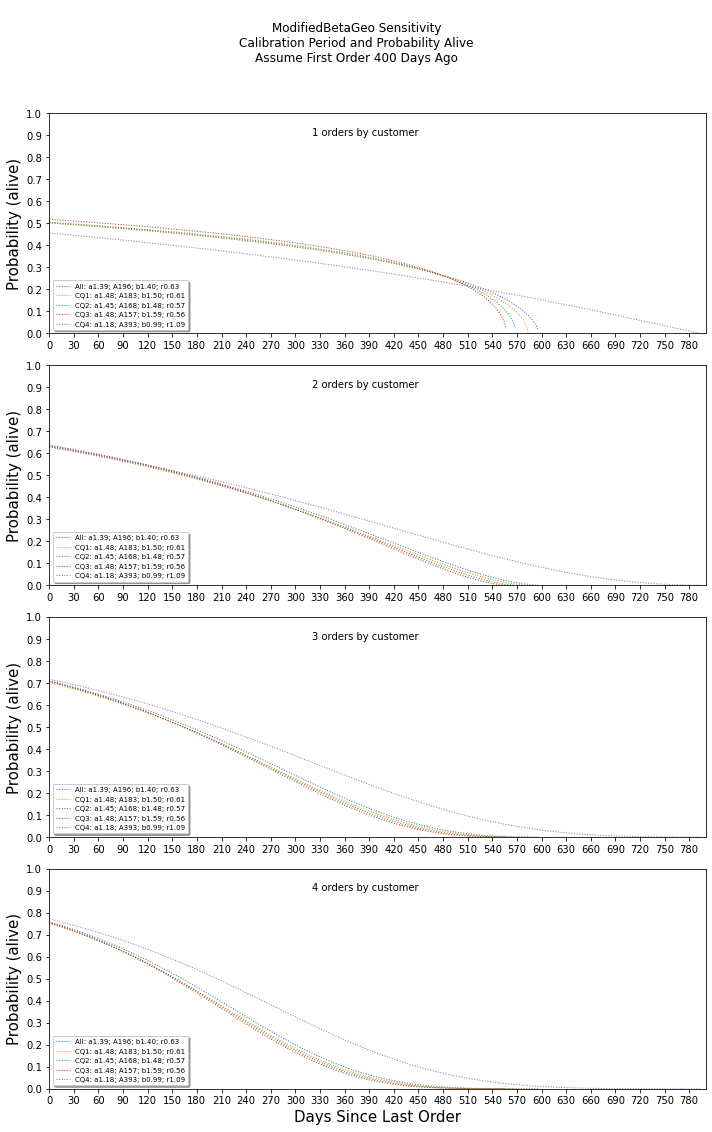

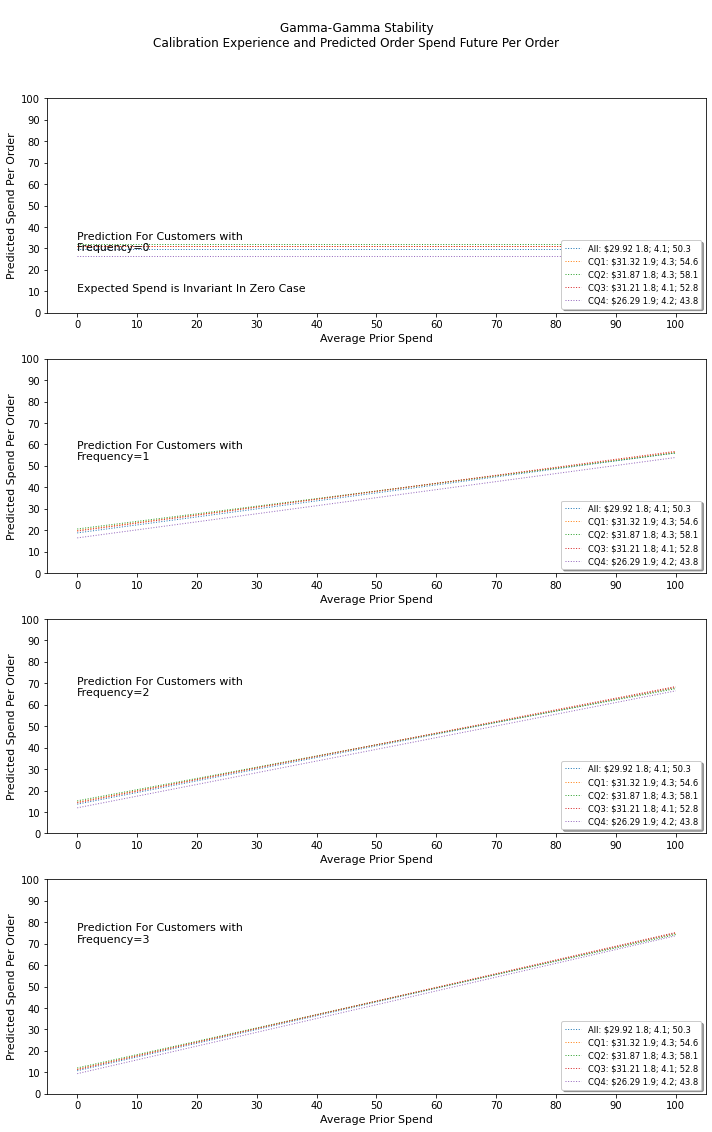

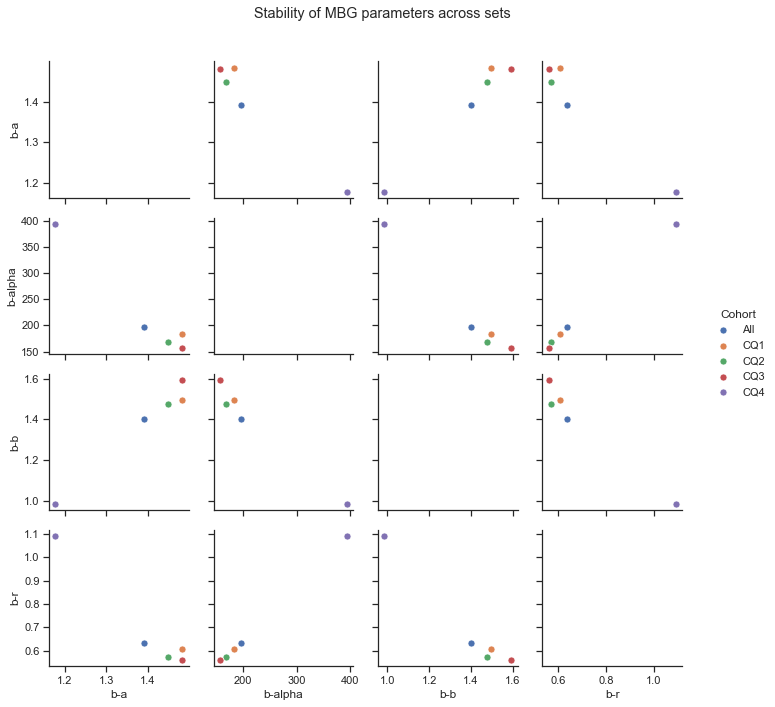

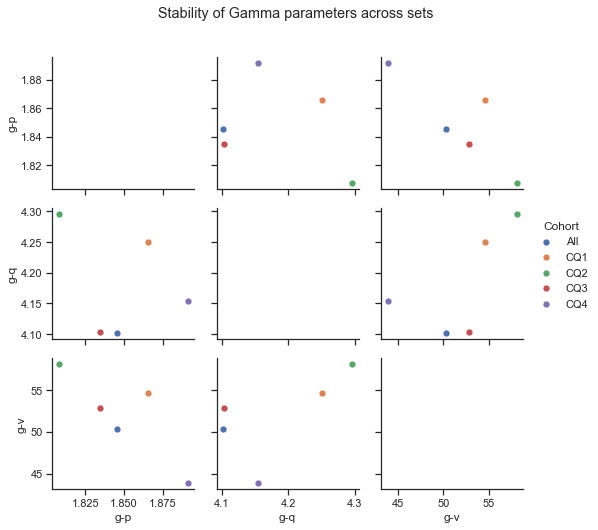

..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency))
..\src\lifetime_dev\VPLifetimesHoldoutPlots.py:442: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 / (1 + (a / (b + frequency)) * ((al

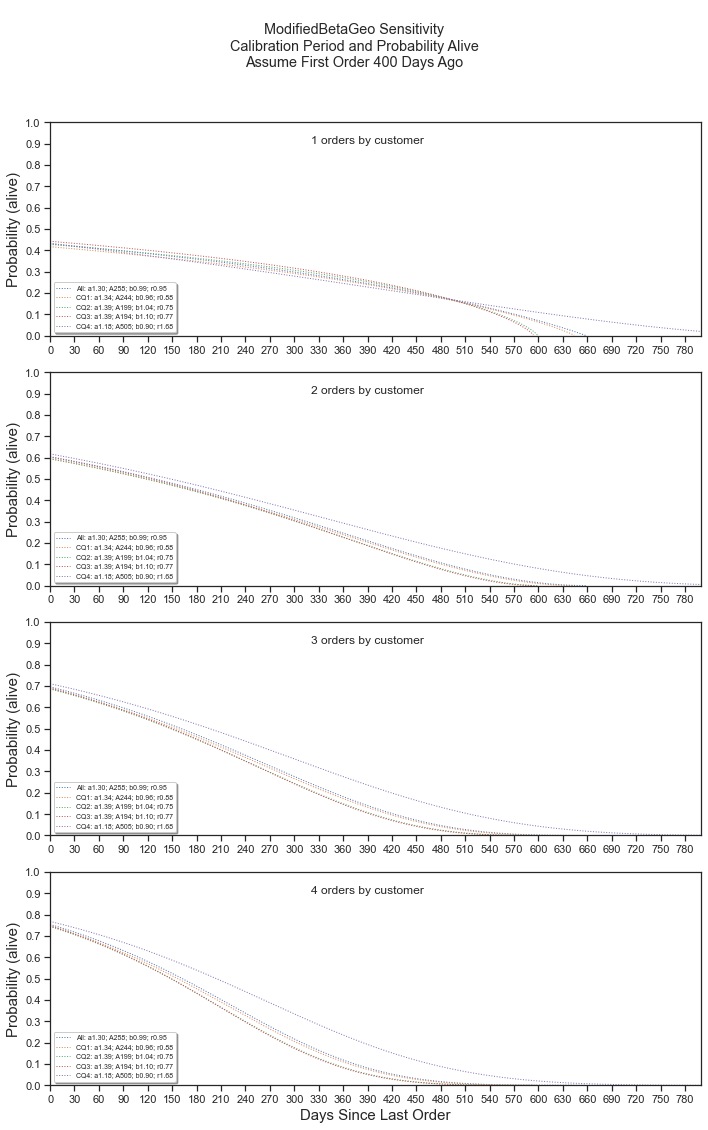

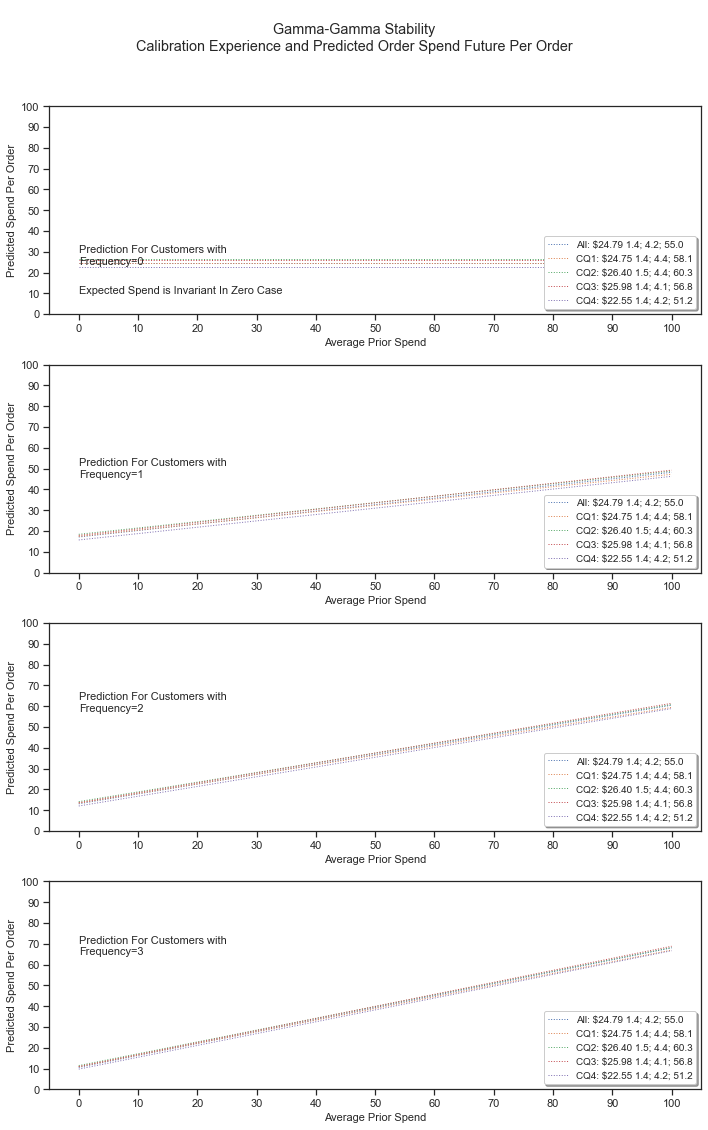

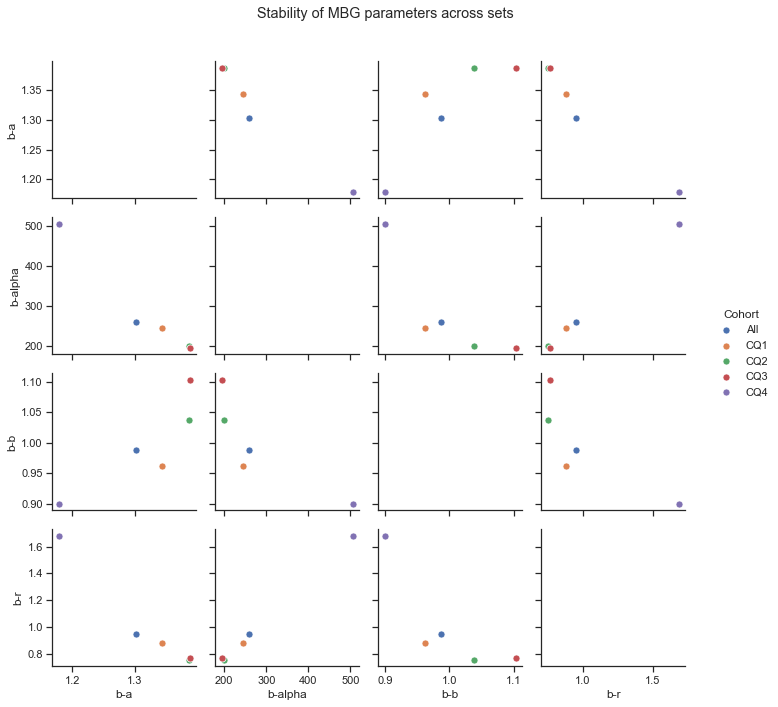

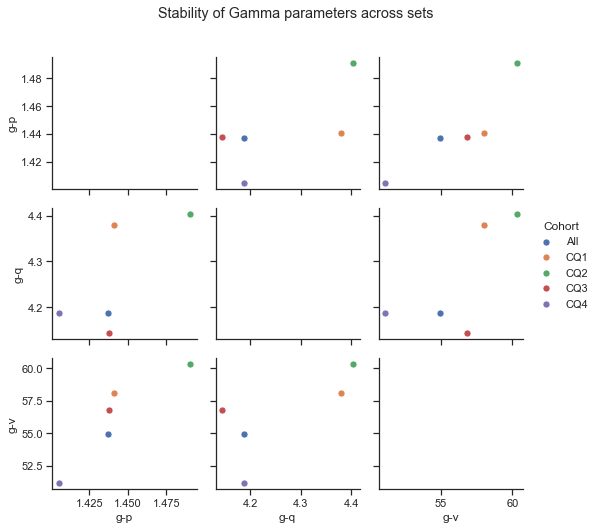

In [10]:
for country in countries:
    subset_df = results_df[results_df.country==country]
    subset_df['Cohort'] = 'CQ' + subset_df['cohort']  # label of legend will be Cohort
    subset_df.loc[subset_df.Cohort=='CQbase', 'Cohort'] = 'All'
    VPLifetimesHoldoutPlots.plot_beta_sensitivity_sets(subset_df, 'Cohort', max_frequency=4)
    plt.show()
    VPLifetimesHoldoutPlots.plot_gamma_gamma_sensitivity_sets(subset_df, 'Cohort')
    plt.show()
    beta_vars = ['Cohort', 'b-a', 'b-alpha', 'b-b', 'b-r']
    gamma_vars = ['Cohort', 'g-p', 'g-q', 'g-v']
    VPLifetimesHoldoutPlots.plot_parameter_stability_pairplot(subset_df[beta_vars], 'Cohort',
                                                              plot_title='Stability of MBG parameters across sets')
    plt.show()
    VPLifetimesHoldoutPlots.plot_parameter_stability_pairplot(subset_df[gamma_vars], 'Cohort',
                                                             plot_title='Stability of Gamma parameters across sets')
    plt.show()

### Gamma-Gamma Charts

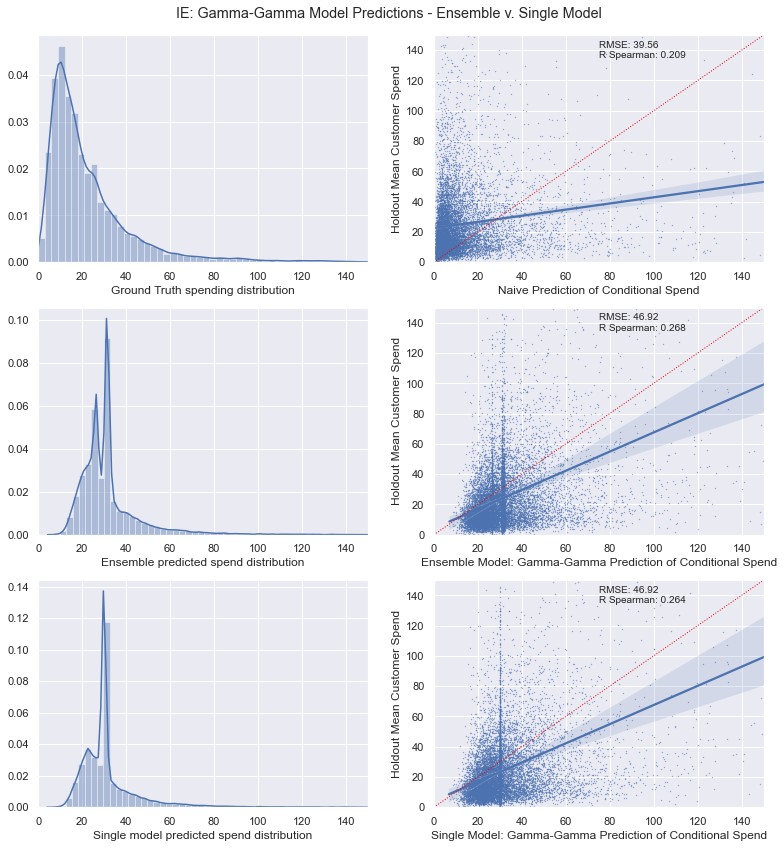

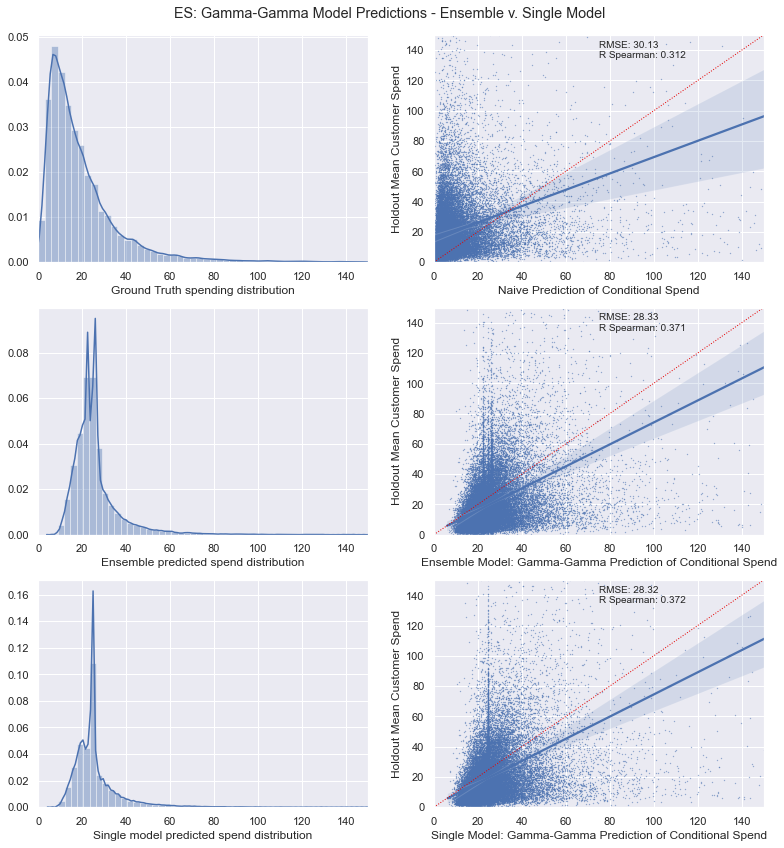

In [11]:
max_spend = 150
for country in countries:
    country_df = country_combined[country]
    purchasers = country_df[country_df.frequency_holdout > 0].copy()
    purchasers['naive_mon_avg'] =  purchasers.monetary_value_cal.div(purchasers.frequency_cal)
    purchasers['holdout_mon_avg'] = purchasers.monetary_value_holdout.div(purchasers.frequency_holdout)
    purchasers['predict_mon_avg'] = purchasers.predict_total_spend.div(purchasers.predict_order_count)

    sns.set_style("darkgrid")
    fig, axes = plt.subplots(3, 2, figsize=(13,13))
    # kde and hist work out better when drawn over limited range
    valid=purchasers[purchasers.holdout_mon_avg < max_spend]
    ax = sns.distplot(valid.holdout_mon_avg, ax=axes[0,0])
    ax.set_xlim(0, max_spend)
    ax.set_xlabel('Ground Truth spending distribution')

    ax = VPLifetimesHoldoutPlots.plot_exp_spend_accuracy_scatter(purchasers,
                                   'Naive Prediction of Conditional Spend',
                                   'naive_mon_avg',
                                   'holdout_mon_avg',
                                    max_spend=150,
                                    annotation_font_size=10,
                                   ax=axes[0, 1])
    # Ensemble model
    valid=purchasers[purchasers.predict_mon_avg < max_spend]
    ax = sns.distplot(valid.predict_mon_avg, ax=axes[1,0])
    ax.set_xlim(0, max_spend)
    ax.set_xlabel('Ensemble predicted spend distribution')

    
    
    ax = VPLifetimesHoldoutPlots.plot_exp_spend_accuracy_scatter(purchasers,
                                   'Ensemble Model: Gamma-Gamma Prediction of Conditional Spend',
                                   'predict_mon_avg',
                                   'holdout_mon_avg',
                                    max_spend=150,
                                    annotation_font_size=10,
                                   ax=axes[1, 1])
    

    country_df = base_dfs[country]
    purchasers = country_df[country_df.frequency_holdout > 0].copy()
    purchasers['naive_mon_avg'] =  purchasers.monetary_value_cal.div(purchasers.frequency_cal)
    purchasers['holdout_mon_avg'] = purchasers.monetary_value_holdout.div(purchasers.frequency_holdout)
    purchasers['predict_mon_avg'] = purchasers.predict_total_spend.div(purchasers.predict_order_count)
        
    # Single model
    valid=purchasers[purchasers.predict_mon_avg < max_spend]
    ax = sns.distplot(valid.predict_mon_avg, ax=axes[2,0])
    ax.set_xlim(0, max_spend)
    ax.set_xlabel('Single model predicted spend distribution')

    ax = VPLifetimesHoldoutPlots.plot_exp_spend_accuracy_scatter(purchasers,
                                   'Single Model: Gamma-Gamma Prediction of Conditional Spend',
                                   'predict_mon_avg',
                                   'holdout_mon_avg',
                                    max_spend=150,
                                    annotation_font_size=10,
                                   ax=axes[2, 1])
    
    plt.subplots_adjust(top=0.95)
    plt.suptitle(f'{country}: Gamma-Gamma Model Predictions - Ensemble v. Single Model')
    plt.show()

